### Import libraries

In [1]:
import numpy as np
import cv2
import copy
import glob
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

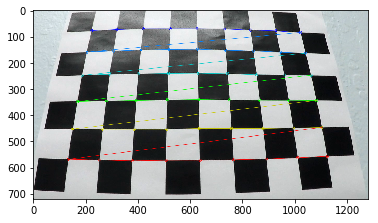

In [2]:
# Prepare Object Points
nx = 9
ny = 6
Objp = np.zeros((nx*ny, 3), np.float32)
Objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Import Calibration Images
calibration_images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(Objp)
        imgpoints.append(corners)

        # Draw and display the corners of '3.jpg'
        if fname[-6:-4] == 'n3':
            img = cv2.drawChessboardCorners(img, (nx,ny), corners,ret)
            plt.imshow(img)
            plt.show()
            
# Import 3.jpg for Later Use
image_3 = cv2.imread('./camera_cal/calibration{}.jpg'.format(3))

In [3]:
# Calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
dist

array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

### 2. Apply a distortion correction to raw images.

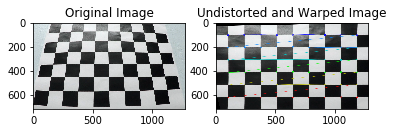

In [4]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], 
                          [img_size[0]-offset, offset], 
                          [img_size[0]-offset, img_size[1]-offset],
                          [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M

# Undistored and Unwarp Image
warped, M = corners_unwarp(image_3, nx, ny, mtx, dist)

# Display Images
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_3)
ax1.set_title('Original Image')
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image')
plt.show()

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# Define a function that takes an image, gradient orientation, and threshold min/max values
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

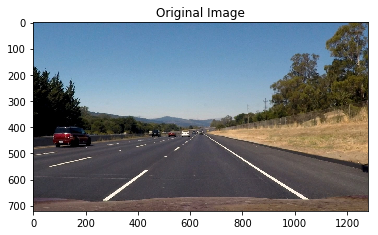

In [6]:
test_img = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(test_img)
plt.title('Original Image')
plt.show()

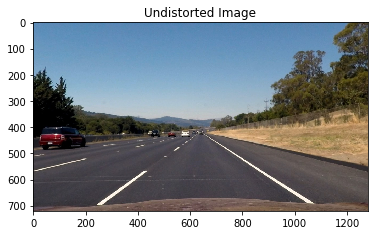

In [7]:
# Undistord image
undist = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.title('Undistorted Image')
plt.show()

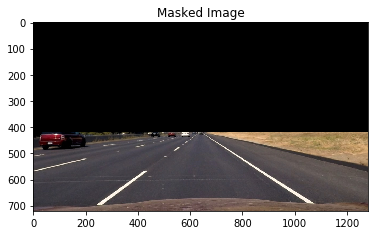

In [8]:
# Mask top portion of image
test_img = copy.deepcopy(undist)
test_img[0:420, 0:1280] = [0, 0, 0]
plt.imshow(test_img)
plt.title('Masked Image')
plt.show()

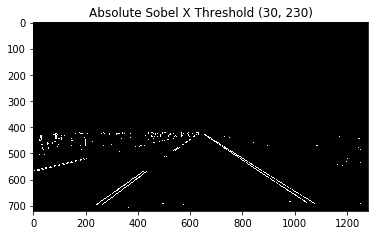

In [9]:
# Apply Absolute Sobel Threshold
abs_sobel_min = 30
abs_sobel_max = 230
abs_sobelx = abs_sobel_thresh(test_img, 'x', abs_sobel_min, abs_sobel_max)
plt.imshow(abs_sobelx, cmap='gray')
plt.title('Absolute Sobel X Threshold ({}, {})'.format(abs_sobel_min, abs_sobel_max))
plt.show()

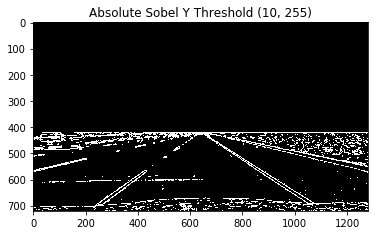

In [10]:
# Apply Absolute Sobel Threshold
abs_sobel_min = 10
abs_sobel_max = 255
abs_sobely = abs_sobel_thresh(test_img, 'y', abs_sobel_min, abs_sobel_max)
plt.imshow(abs_sobely, cmap='gray')
plt.title('Absolute Sobel Y Threshold ({}, {})'.format(abs_sobel_min, abs_sobel_max))
plt.show()

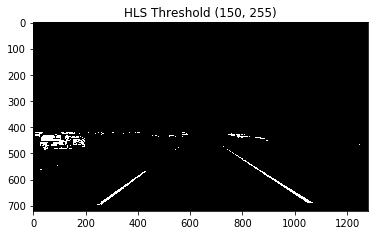

In [11]:
# Apply HLS Threshold
hls_thresh = (150, 255)
hls_img = hls_select(test_img, hls_thresh)
plt.imshow(hls_img, cmap='gray')
plt.title('HLS Threshold {}'.format(hls_thresh))
plt.show()

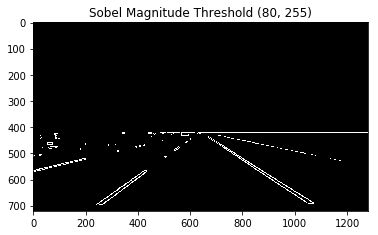

In [12]:
# Apply Sobel Magnitude Threshold
mag_thresh = (80, 255)
sobel_kernel = 9
sobel_mag_img = sobel_mag_thresh(test_img, sobel_kernel, mag_thresh)
plt.imshow(sobel_mag_img, cmap='gray')
plt.title('Sobel Magnitude Threshold {}'.format(mag_thresh))
plt.show()

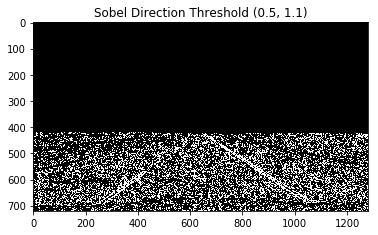

In [13]:
# Apply Sobel Direction Threshold
dir_thresh = (0.5, 1.1)
sobel_kernel = 3
sobel_dir_img = sobel_dir_threshold(test_img, sobel_kernel, dir_thresh)
plt.imshow(sobel_dir_img, cmap='gray')
plt.title('Sobel Direction Threshold {}'.format(dir_thresh))
plt.show()

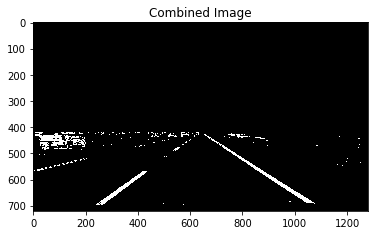

In [14]:
# Combining all filters
combined = np.zeros_like(abs_sobelx)
combined[((abs_sobelx == 1)&(abs_sobely==1)) | (hls_img==1) | ((sobel_mag_img==1)&(sobel_dir_img==1))] = 1
# combined[(hls_img==1)] = 1
plt.imshow(combined, cmap='gray')
plt.title('Combined Image')
plt.show()

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [15]:
def warp_img(img, src, dst, img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

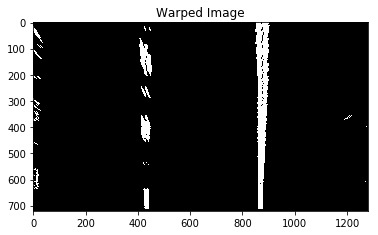

In [16]:
# Apply warp_img to test image
src = np.float32([[595,450],[683,450],[1070,720],[210,720]])
dst = np.float32([[430,0],[1280-430,0],[1280-430,720],[430,720]])
img_size = (combined.shape[1], combined.shape[0])
warped, M, Minv = warp_img(combined, src, dst, img_size)
plt.imshow(warped, cmap='gray')
plt.title('Warped Image')
plt.show()

### 5. Detect lane pixels and fit to find the lane boundary.

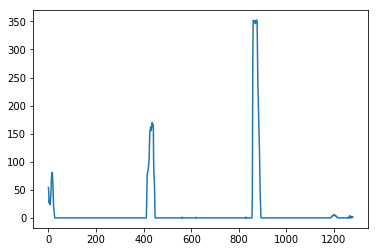

In [17]:
# Histogram on test image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [18]:
def polyfit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds
    
left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = polyfit(warped)

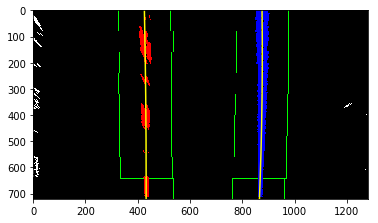

In [19]:
# Generate x and y values for plotting
binary_warped = warped
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [20]:
def position(left_fitx, right_fitx):
    position = 1280/2
    left  = left_fitx[-1]
    right = right_fitx[-1]
    center = (left + right)/2
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    
    return (position - center)*xm_per_pix


def curvature(fitx):
    yvals = np.linspace(0, 719, num=720)
    y_eval = np.max(yvals)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    
    return curverad

### 7. Warp the detected lane boundaries back onto the original image.

In [21]:
def warp_back(image, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

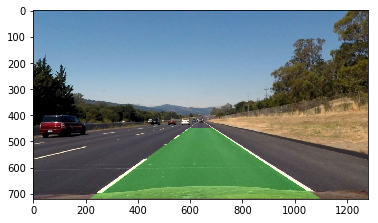

In [22]:
result = warp_back(undist, warped, left_fitx, right_fitx, ploty)
plt.imshow(result)
plt.show()

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [23]:
def polyfit_process(binary_warped):
    
    if left_line_.detected:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit

In [24]:
def process_image_example(image):
    
    # Undistord image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Mask image
    masked = copy.deepcopy(undist)
    masked[0:420, 0:1280] = [0, 0, 0]
    
    
    # Apply Absolute Sobel Threshold
    abs_sobel_min = 30
    abs_sobel_max = 230
    abs_sobelx = abs_sobel_thresh(masked, 'x', abs_sobel_min, abs_sobel_max)
    
    # Apply Absolute Sobel Threshold
    abs_sobel_min = 10
    abs_sobel_max = 255
    abs_sobely = abs_sobel_thresh(masked, 'y', abs_sobel_min, abs_sobel_max)
    
    # Apply HLS Threshold
    hls_thresh = (150, 255)
    hls_img = hls_select(masked, hls_thresh)
    
    # Apply Sobel Magnitude Threshold
    mag_thresh = (80, 255)
    sobel_kernel = 9
    sobel_mag_img = sobel_mag_thresh(masked, sobel_kernel, mag_thresh)
    
    # Apply Sobel Direction Threshold
    dir_thresh = (0.5, 1.1)
    sobel_kernel = 3
    sobel_dir_img = sobel_dir_threshold(masked, sobel_kernel, dir_thresh)
    
    # Combining all filters
    combined = np.zeros_like(abs_sobely)
    combined[((abs_sobelx == 1)&(abs_sobely==1)) | (hls_img==1) | ((sobel_mag_img==1)&(sobel_dir_img==1))] = 1
    
    # Apply warp_img to test image
    src = np.float32([[595,450],[683,450],[1070,720],[210,720]])
    dst = np.float32([[430,0],[1280-430,0],[1280-430,720],[430,720]])
    img_size = (combined.shape[1], combined.shape[0])
    warped, M, Minv = warp_img(combined, src, dst, img_size)
    
    # Apply lane line polyfit
    left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = polyfit(warped)
    
    # Generate x and y values for plotting
    binary_warped = warped
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Get position and curvature
    pos = position(left_fitx, right_fitx)
    cur = (curvature(left_fitx) + curvature(right_fitx)) / 2.0
    
    # Apply warp back
    result = warp_back(undist, warped, left_fitx, right_fitx, ploty)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(cur))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    
    # Find the position of the car
    if pos < 0:
        text = "Vehicle is {:.2f} m left of center".format(-pos)
    else:
        text = "Vehicle is {:.2f} m right of center".format(pos)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    return result

def process_image(image):
    
    # Undistord image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Mask image
    masked = copy.deepcopy(undist)
    masked[0:420, 0:1280] = [0, 0, 0]
    
    
    # Apply Absolute Sobel Threshold
    abs_sobel_min = 30
    abs_sobel_max = 230
    abs_sobelx = abs_sobel_thresh(masked, 'x', abs_sobel_min, abs_sobel_max)
    
    # Apply Absolute Sobel Threshold
    abs_sobel_min = 10
    abs_sobel_max = 255
    abs_sobely = abs_sobel_thresh(masked, 'y', abs_sobel_min, abs_sobel_max)
    
    # Apply HLS Threshold
    hls_thresh = (150, 255)
    hls_img = hls_select(masked, hls_thresh)
    
    # Apply Sobel Magnitude Threshold
    mag_thresh = (80, 255)
    sobel_kernel = 9
    sobel_mag_img = sobel_mag_thresh(masked, sobel_kernel, mag_thresh)
    
    # Apply Sobel Direction Threshold
    dir_thresh = (0.5, 1.1)
    sobel_kernel = 3
    sobel_dir_img = sobel_dir_threshold(masked, sobel_kernel, dir_thresh)
    
    # Combining all filters
    combined = np.zeros_like(abs_sobely)
    combined[((abs_sobelx == 1)&(abs_sobely==1)) | (hls_img==1) | ((sobel_mag_img==1)&(sobel_dir_img==1))] = 1
    
    # Apply warp_img to test image
    src = np.float32([[595,450],[683,450],[1070,720],[210,720]])
    dst = np.float32([[430,0],[1280-430,0],[1280-430,720],[430,720]])
    img_size = (combined.shape[1], combined.shape[0])
    warped, M, Minv = warp_img(combined, src, dst, img_size)
    
    # Apply lane line polyfit
    left_fit, right_fit = polyfit_process(warped)
    
    # Generate x and y values for plotting
    binary_warped = warped
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Get position and curvature
    pos = position(left_fitx, right_fitx)
    cur = (curvature(left_fitx) + curvature(right_fitx)) / 2.0
    
    # Sanity Check
    if (left_line_.recent_xfitted is not None) & (abs((left_line_.recent_xfitted[0] - left_fitx[0]) / left_fitx[0]) > 0.1):
        left_fitx = left_line_.recent_xfitted
    elif (right_line_.recent_xfitted is not None) & (abs((right_line_.recent_xfitted[0] - right_fitx[0]) / right_fitx[0]) > 0.1):
        right_fitx = right_line_.recent_xfitted
    else:
        right_line_.recent_xfitted = right_fitx
        left_line_.recent_xfitted = left_fitx
        
    left_line_.detected = True
    
    # Apply warp back
    result = warp_back(undist, warped, left_fitx, right_fitx, ploty)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(cur))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    
    # Find the position of the car
    if pos < 0:
        text = "Vehicle is {:.2f} m left of center".format(-pos)
    else:
        text = "Vehicle is {:.2f} m right of center".format(pos)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    return result

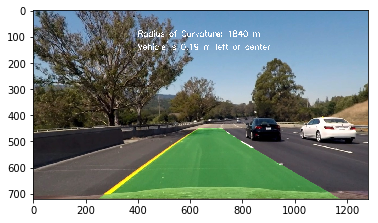

In [25]:
a = mpimg.imread('./test_images/test6.jpg')
final = process_image_example(a)
plt.imshow(final, cmap='gray')
plt.show()

In [26]:
#from moviepy.editor import VideoFileClip
#left_line_ = Line()
#right_line_ = Line()
#white_output = 'advanced_lane_finding.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)